# Conditional GAN (cGAN)

## Imports e FID

In [1]:
import torch
import torchvision
import torch.utils.data.dataloader as dataloader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import time

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(f"Running on {device}")

Running on cuda:0


* Código obtido de https://pytorch.org/hub/pytorch_vision_inception_v3/
* O seguinte link menciona como converter de Grayscale para o RGB visualmente equivalente (https://discuss.pytorch.org/t/grayscale-to-rgb/94639/2)
* Implementação do FID retirada de https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

In [2]:
## code taken from https://pytorch.org/hub/pytorch_vision_inception_v3/
model_inceptionV3 = torchvision.models.inception_v3(weights=torchvision.models.Inception_V3_Weights.DEFAULT).to(device)
model_inceptionV3.eval() # evaluation/inference mode

preprocess = transforms.Compose([
    transforms.Lambda(lambda img: img.expand(-1, 3, -1, -1)),  # Acts on batch. From grayscale to RGB with R=G=B = original channel intensity
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
# remove fc layers
model_inceptionV3._modules["dropout"] = nn.Identity()
model_inceptionV3._modules["fc"] = nn.Identity()

print(f"Total parameters: {sum(x.numel() for x in model_inceptionV3.parameters() if x.requires_grad)}")

Total parameters: 25112264


In [4]:
from scipy.linalg import sqrtm # principal square root of positive (semi)definite matrix

def FID_score(real_batch: torch.Tensor, fake_batch: torch.Tensor):
    act1 = preprocess(real_batch).to(device)
    act2 = preprocess(fake_batch).to(device)

    ## inference only
    with torch.no_grad():
        act1 = model_inceptionV3(act1)
        act2 = model_inceptionV3(act2)

    ## pass to cpu and then convert to numpy array
    act1 = act1.cpu().detach().numpy()
    act2 = act2.cpu().detach().numpy()

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    mean_dist_square = np.sum((mu1 - mu2)**2)
    sqrt_cov = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(sqrt_cov):
        sqrt_cov = sqrt_cov.real

    return mean_dist_square + np.trace(sigma1 + sigma2 - 2.0 * sqrt_cov)

## 0. Parameters

In [5]:
# parameters
# root = "/home/igor/IC-iVision/CIFAR10"
root = "/home/igor/IC-iVision/MNIST"
img_size = (28, 28)
batch_size = 25
workers = 0

In [6]:
num_classes = 10
nc = 1 # num channels
nz = 100
n_embed = 10
leaky_slope = 0.2
lr = 0.0002
betas=(0.5, 0.999)
g_hidden_layers = [128, 256, 512, 1024, 2048, 4096]
d_hidden_layers = [2048, 4096, 2048, 512, 256]
# criterion = nn.BCELoss() # y log x + (1 - y) log (1 - x) where x,y are of shape (batch_size,)
criterion = nn.MSELoss()

### ADA
p = 0.0
ada_N = 5  ## number of minibatches after which update probability of random data augmentation transforms
delta_p = 0.05
max_p = 0.8
min_p = 0.0
target_rt = 0.6  ## reference RT for measuring overfitting

## 1. Loading

In [7]:
## loading

## use only training images to make loading easier
dataset = datasets.MNIST(root=root, train=True,
                           transform=transforms.Compose([
                               # transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Resize(img_size),
                               # transforms.Normalize([0.5], [0.5]), # normalize single channel
                               transforms.Grayscale()
                           ]),
                           download=True)

print(f"Loaded {len(dataset)} images of {len(dataset.classes)} classes")
print("Classes:", *dataset.classes, sep="\n\t")

dl = dataloader.DataLoader(dataset, batch_size=batch_size,
                           shuffle=True,
                           num_workers=workers)

Loaded 60000 images of 10 classes
Classes:
	0 - zero
	1 - one
	2 - two
	3 - three
	4 - four
	5 - five
	6 - six
	7 - seven
	8 - eight
	9 - nine


### 1.2 Plotting one batch

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


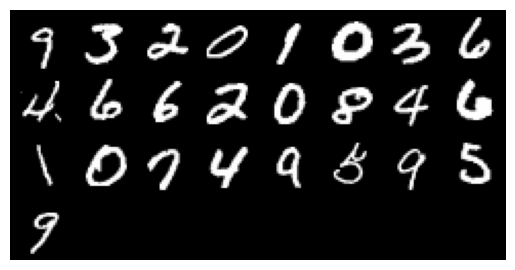

FID score of -7.72789462986613e-05. Expected 0.0.


In [8]:
img_batch, labels = next(iter(dl))

# plt.rcParams["figure.figsize"] = (20, 20)

img_grid = vutils.make_grid(img_batch, 8)
img_grid = np.transpose(img_grid, (1, 2, 0))
plt.axis("off")

plt.imshow(img_grid)
plt.show()

print(f"FID score of {FID_score(img_batch, img_batch)}. Expected 0.0.") ## for FID testing purposes

### 1.3 Data augmentation

* Ver o artigo [Training Generative Adversarial Networks with
Limited Data](https://arxiv.org/abs/2006.06676) para uma descrição mais detalhada do método ADA (Adaptive Discriminator Augmentation), bem como um _pipeline_ de transformações de imagens mais completo que o seguinte (que só inclui transformaçoẽs envolvendo _pixel blittin_, movimentação de pixels).

In [9]:
def data_augmentation_layers(curr_p : float):
    """Using only pixel_blitting layers for now.

    Randomization, according to the paper, should be done for each transformation"""
    x_flip = transforms.RandomHorizontalFlip(curr_p)
    rotation_90 = transforms.RandomApply([transforms.RandomRotation(90)], curr_p)
    translation = transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.3))], curr_p)

    return transforms.Compose([
        x_flip,
        rotation_90,
        translation
    ])

augment_transforms= data_augmentation_layers(p) ## First/base instance of data augmentation layers

## 2. Creating network

### 2.1 Generator

In [10]:
class cGenerator(nn.Module):
    def __init__(self):
        super(cGenerator, self).__init__()
        self.all_layers = [nz + n_embed] + g_hidden_layers
        self.main = nn.ModuleList()
        for i in range(len(self.all_layers) - 1):
            in_size = self.all_layers[i]
            out_size = self.all_layers[i + 1]
            self.main.append(nn.Linear(in_features=in_size, out_features=out_size))
            self.main.append(nn.BatchNorm1d(out_size))
            self.main.append(nn.LeakyReLU(negative_slope=leaky_slope, inplace=True))
        self.main.append(nn.Linear(self.all_layers[-1], nc * img_size[0] * img_size[1]))
        self.main.append(nn.Tanh())

        self.embedding = nn.Embedding(num_embeddings=num_classes, embedding_dim=n_embed)

    def forward(self, z, y):
        embedded_y = self.embedding(y)
        tensor = torch.cat([z, embedded_y], dim=-1)
        for layer in self.main:
            tensor = layer(tensor)
        return tensor.view(-1, nc, img_size[0], img_size[1])

In [11]:
netG = cGenerator().to(device) # generator on GPU

optimG = optim.Adam(params=netG.parameters(), lr=lr, betas=betas)

In [12]:
print(netG)
print(f"Total parameters: {sum(x.numel() for x in netG.parameters() if x.requires_grad)}")

cGenerator(
  (main): ModuleList(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Linear(in_features=1024, out_features=2048, bias=True)
    (13): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_runni

### 2.2 Discriminator

In [13]:
class cDiscriminator(nn.Module):
    def __init__(self):
        super(cDiscriminator, self).__init__()
        self.all_layers = [nc * img_size[0] * img_size[1] + n_embed] + d_hidden_layers
        self.main = nn.ModuleList()
        for i in range(len(self.all_layers) - 1):
            in_size = self.all_layers[i]
            out_size = self.all_layers[i + 1]
            self.main.append(nn.Linear(in_features=in_size, out_features=out_size))
            self.main.append(nn.LeakyReLU(negative_slope=leaky_slope, inplace=True))
        self.main.append(nn.Linear(self.all_layers[-1], 1))
        self.main.append(nn.Sigmoid())

        self.embedding = nn.Embedding(num_embeddings=num_classes, embedding_dim=n_embed)

    def forward(self, x, y):
        flattened_x = torch.flatten(x, 1)
        embedded_y = self.embedding(y)
        tensor = torch.cat([flattened_x, embedded_y], dim=-1)
        for layer in self.main:
            tensor = layer(tensor)
        return tensor

In [14]:
netD = cDiscriminator().to(device) # discriminator on GPU

optimD = optim.Adam(params=netD.parameters(), lr=lr, betas=betas)

In [15]:
print(netD)
print(f"Total parameters: {sum(x.numel() for x in netD.parameters() if x.requires_grad)}")

cDiscriminator(
  (main): ModuleList(
    (0): Linear(in_features=794, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=2048, out_features=4096, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=4096, out_features=2048, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=2048, out_features=512, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Linear(in_features=256, out_features=1, bias=True)
    (11): Sigmoid()
  )
  (embedding): Embedding(10, 10)
)
Total parameters: 19592293


## 3 Training

### 3.1 Some definitions

#### 3.1.1 Plotting function (for visual comparison)

In [16]:
def plot_side_by_side(img_batch, labels_batch):
    plt.rcParams["figure.figsize"] = (20, 20)
    plt.subplots_adjust(wspace=1.0, hspace=1.0)

    fig, ax = plt.subplots(1, 2)

    noise = torch.randn(batch_size, nz, device=device)
    with torch.no_grad():
        fake_batch = netG(noise.to(device), labels_batch.to(device)).cpu()

    real_grid = torchvision.utils.make_grid(img_batch.cpu(), 8, normalize=True) # image grid
    real_grid = np.transpose(real_grid, (1, 2, 0)) # reshape images from [num_channels, H, W] to [H, W, num_channels]
    ax[0].set_title("Batch of real images")
    ax[0].imshow(real_grid, cmap="gray")
    ax[0].axis("off")

    fake_grid = torchvision.utils.make_grid(fake_batch, 8, normalize=True) # image grid
    fake_grid = np.transpose(fake_grid, (1, 2, 0)) # reshape images from [num_channels, H, W] to [H, W, num_channels]
    ax[1].set_title("Batch of generated images")
    ax[1].imshow(fake_grid, cmap="gray")
    ax[1].axis("off")

    plt.show()

#### 3.1.2 Model checkpoint setup

In [17]:
best_fid = float('inf')
GEN_PATH = "weights/generator.pth"
DISC_PATH = "weights/discriminator.pth"

#### 3.1.3 Training state variables

In [18]:
# training loop
D_loss_hist = []
D_real_hist = []
D_fake_hist = []
G_loss_hist = []
fid_hist = []
total_epochs_trained = 0

ada_sign_D_train_lastN = []

### 3.2 Training loop

In [19]:
def train(curr_epochs: int, D_loss_hist: list, D_real_hist: list,
          D_fake_hist: list, G_loss_hist: list, fid_hist: list, * ,
          max_time_sec: float = float('inf'), max_epochs: int = 10_000):
    global best_fid, augment_transforms, ada_sign_D_train_lastN, p

    init_time = time.time()
    for i in range(max_epochs):
        D_loss = 0.0
        D_real = 0.0
        D_fake = 0.0
        G_loss = 0.0

        for j, (real_batch, y_batch) in enumerate(dl):
            ## move to GPU
            real_batch = real_batch.to(device) # load images in GPU
            y_batch = y_batch.to(device) # load labels to GPU

            ## do data augmentation (LIVE)
            real_batch = augment_transforms(real_batch)

            ## generate noise
            curr_batch_size = real_batch.shape[0]
            noise = torch.randn([curr_batch_size, nz], device=device)
            conditional_noise = torch.randint(0, num_classes, (curr_batch_size,), device=device)
            ## aux statments
            real_label = torch.full((curr_batch_size,), 1, dtype=torch.float, device=device)
            fake_label = torch.full((curr_batch_size,), 0, dtype=torch.float, device=device)

            ## generate fake batch
            fake_batch = netG(noise, y_batch)


            # ----- Train discriminator --------
            # zero all gradients
            netD.zero_grad()

            # - 1/m * sum log D(xi)
            real_output = netD(real_batch, y_batch).view(-1)
            D_real_loss = criterion(real_output, real_label)
            D_real_loss.backward() # calcuate gradient
            # - 1/m * sum log (1 - D(G(zi)))
            # the detach makes it ignore the NetG parameter in gradient computation graph
            # (since fake_img_batch = NetG(noise))
            fake_output = netD(fake_batch.detach(), conditional_noise).view(-1)
            D_fake_loss = criterion(fake_output, fake_label)
            D_fake_loss.backward() # calculate (and accumulate) gradient
            # maximize 1/m * sum log D(xi) + 1/m * sum log (1 - D(G(zi)))
            optimD.step()
            # accumulate loss
            D_loss += D_real_loss.item() + D_fake_loss.item()
            # accumulate real and fake outputs
            D_real += real_output.sum().item()
            D_fake += fake_output.sum().item()

            # ----- Train generator -------
            # zero all gradients
            netG.zero_grad()

            # - 1/m * sum log D(G(z))
            # now fake_img_batch should be a part of the gradient computation graph
            fake_output = netD(fake_batch, conditional_noise).view(-1)
            G_loss_batch = criterion(fake_output, real_label)
            G_loss_batch.backward() # calculate gradient
            # maximize 1/m sum log D(G(z)) ==> minimize 1/m sum log(1 - D(G(z)))
            optimG.step()
            # accumulate loss
            G_loss += G_loss_batch.item()

            with torch.no_grad():
                ## ADA logic
                avg_sign_D_j = torch.mean(torch.sign(real_output)).item()
                ada_sign_D_train_lastN.append(avg_sign_D_j) ## final shape (N,)
                if ((j + 1) % ada_N == 0):  # do after every N minibatches
                    rt = np.mean(ada_sign_D_train_lastN)
                    ada_sign_D_train_lastN = []  ## reset list of last N sign means
                    if (rt > target_rt):  # too much overfitting
                        p = np.clip(p + delta_p, min_p, max_p)
                    else:  # too little overfitting
                        p = np.clip(p - delta_p, min_p, max_p)
                    augment_transforms = data_augmentation_layers(p)


        D_real /= len(dataset) # avg D(x)
        D_fake /= len(dataset) # avg D(G(z))

        print(f"Epoch {i + 1}. Generator loss: {G_loss}. " +
            f"Discriminator loss: {D_loss}. " +
            f"Average D(x): {D_real}. Average D(G(z)): {D_fake}")

        ## calculate FID
        with torch.no_grad():
            real_batch, _ = next(iter(dl)) # get new (random?) batch
            noise = torch.randn([batch_size, nz], device=device)
            conditional_noise = torch.randint(0, num_classes, (batch_size,), device=device)
            fake_batch = netG(noise, y_batch)
            fid = FID_score(real_batch, fake_batch)
            print(f"FID score for random batch: {fid}")

        # save for plotting latter
        D_loss_hist.append(D_loss)
        D_real_hist.append(D_real)
        D_fake_hist.append(D_fake)
        G_loss_hist.append(G_loss)
        fid_hist.append(fid)
        curr_epochs += 1

        # plot every 1 epochs
        if ((i + 1) % 1 == 0):
            real_batch, y_batch = next(iter(dl)) # get new (random?) batch
            plot_side_by_side(real_batch, y_batch)

        # check time
        if (time.time() - init_time > max_time_sec):
            return D_loss_hist, D_real_hist, D_fake_hist, G_loss_hist, fid_hist, curr_epochs

        # save best model
        if (fid < best_fid):
            best_fid = fid
            # torch.save(netG, GEN_PATH)
            # torch.save(netD, DISC_PATH)

    return D_loss_hist, D_real_hist, D_fake_hist, G_loss_hist, fid_hist, curr_epochs

Epoch 1. Generator loss: 2030.5907049030066. Discriminator loss: 379.98919163605245. Average D(x): 0.9870061341663202. Average D(G(z)): 0.15519609058291783
FID score for random batch: 436.8378560951552


<Figure size 2000x2000 with 0 Axes>

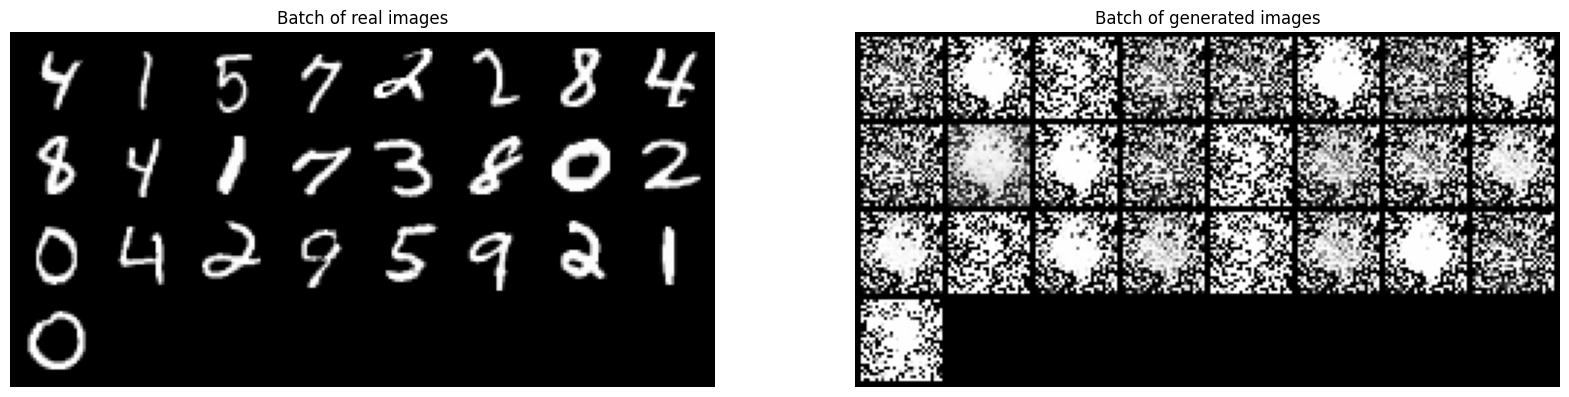

Epoch 2. Generator loss: 2078.4424623980917. Discriminator loss: 346.1026755904862. Average D(x): 0.9900851548333963. Average D(G(z)): 0.13441451800664267
FID score for random batch: 403.81245468251626


<Figure size 2000x2000 with 0 Axes>

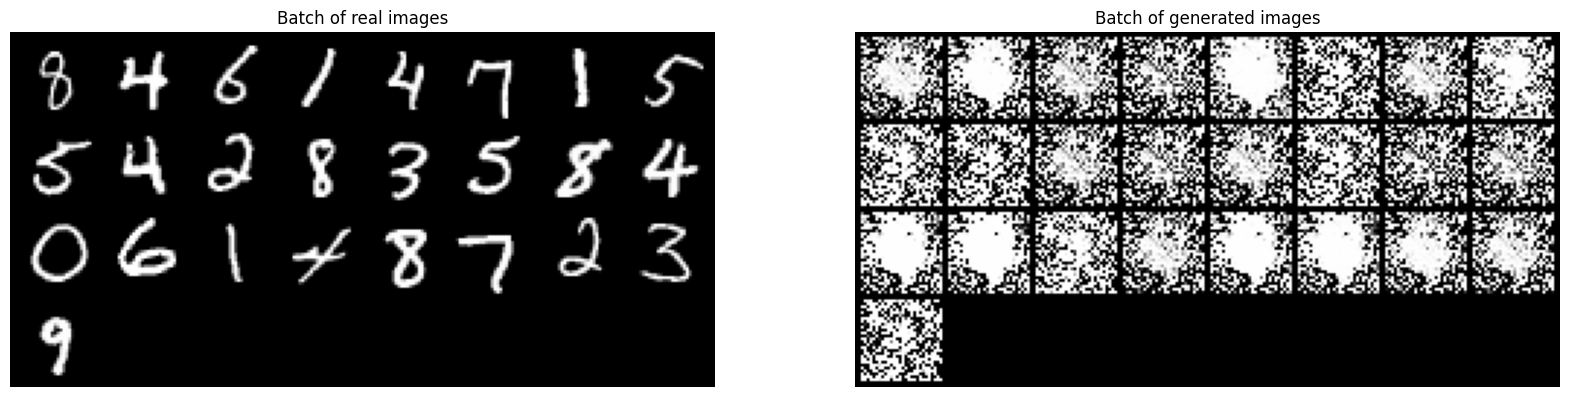

In [20]:
# train for 1h
D_loss_hist, D_real_hist, D_fake_hist, \
G_loss_hist, fid_hist, total_epochs_trained = train(total_epochs_trained,
                                                         D_loss_hist,
                                                         D_real_hist,
                                                         D_fake_hist,
                                                         G_loss_hist,
                                                         fid_hist,
                                                         max_epochs=2)
                                                         #max_time_sec=60*60)

### 3.3 Plot evolution of metrics

Discriminator loss:[379.98919163605245, 346.1026755904862]
Generator loss:[2030.5907049030066, 2078.4424623980917]
Average prediction of real image:[0.9870061341663202, 0.9900851548333963]
Average prediction of fake image:[0.15519609058291783, 0.13441451800664267]


<Figure size 1000x1000 with 0 Axes>

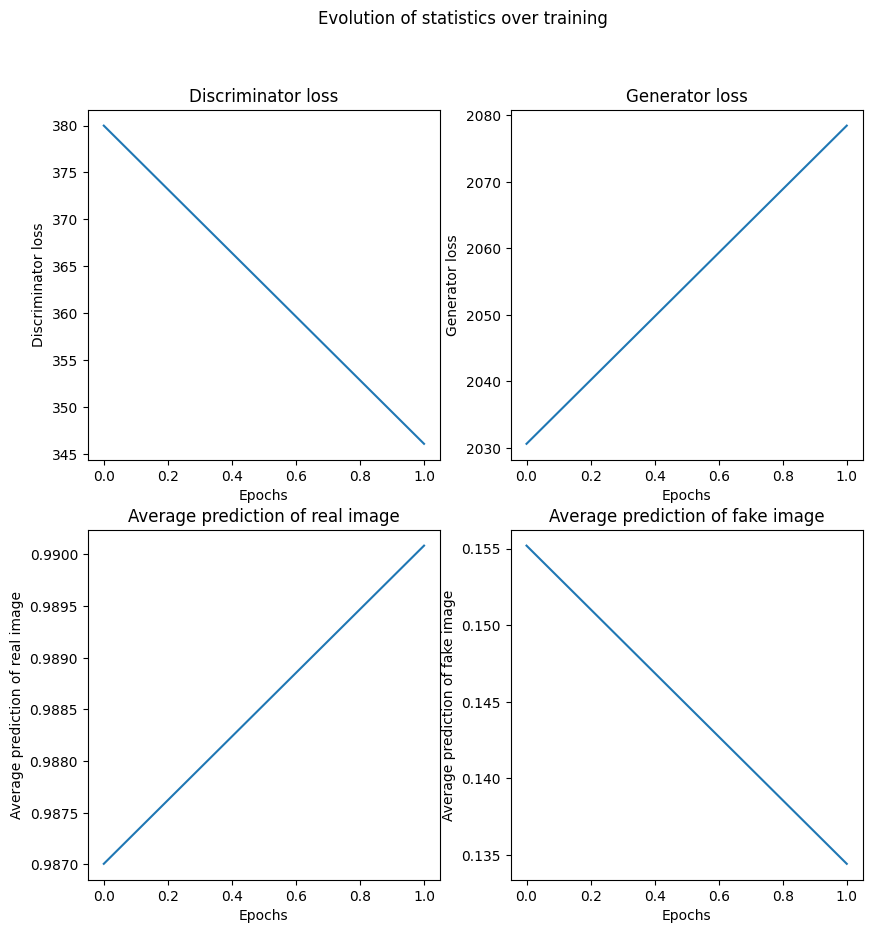

In [21]:
# plot loss evolution

plt.rcParams["figure.figsize"] = (10, 10)
plt.subplots_adjust(wspace=1.0, hspace=1.0)

fig, ax = plt.subplots(2, 2)
fig.suptitle("Evolution of statistics over training")
for i, stat, name in zip(range(4),
                         [D_loss_hist, G_loss_hist, D_real_hist, D_fake_hist],
                         ["Discriminator loss", "Generator loss", "Average prediction of real image", "Average prediction of fake image"]):
    print(f"{name}:{stat}")
    ax[i // 2, i % 2].set_title(name)
    ax[i // 2, i % 2].set_xlabel("Epochs")
    ax[i // 2, i % 2].set_ylabel(name)
    ax[i // 2, i % 2].plot(range(total_epochs_trained), stat)

plt.show()

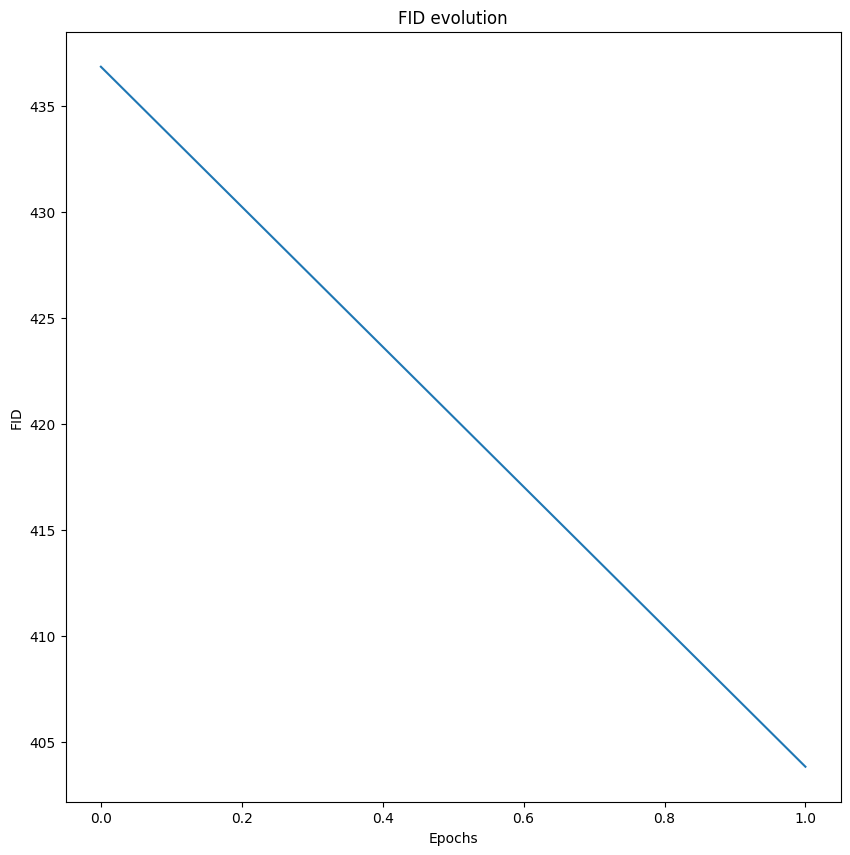

In [22]:
# plot FID evolution

plt.rcParams["figure.figsize"] = (10, 10)
plt.subplots_adjust(wspace=1.0, hspace=1.0)

plt.title("FID evolution")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.plot(range(total_epochs_trained), fid_hist)

## 4. Visualizing real/generated images (side by side)

<Figure size 2000x2000 with 0 Axes>

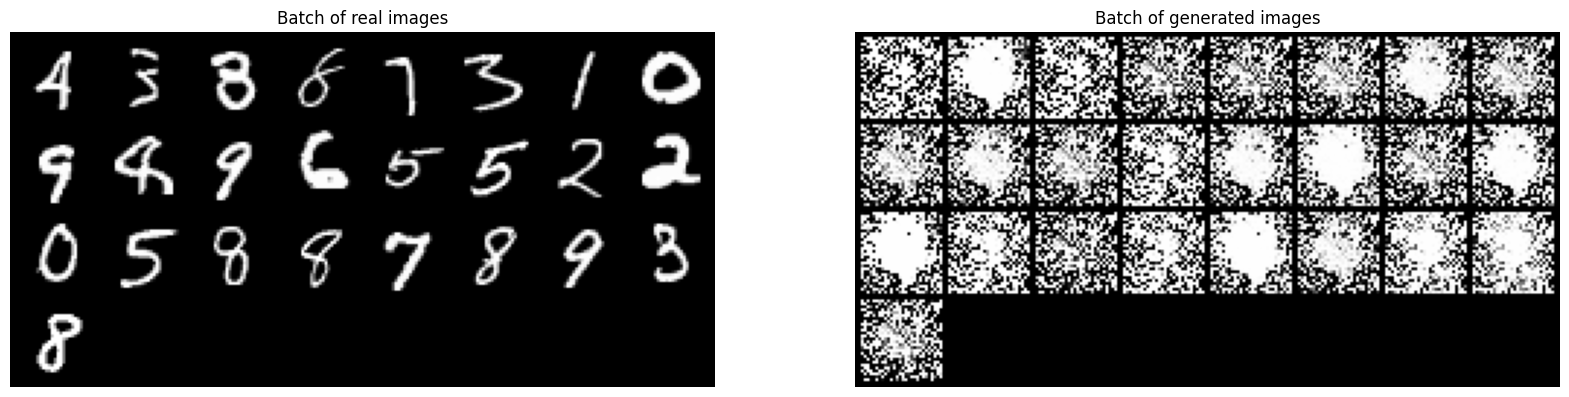

In [23]:
real_batch, labels_batch = next(iter(dl))
plot_side_by_side(real_batch, labels_batch)